# 🦁 LION and Adamax — Sign-based Momentum vs. Infinity-Norm Adam

This notebook compares **LION** (Evolved Sign Momentum) and **Adamax** (an ∞-norm variant of Adam) with rich visual diagnostics:

- Trajectories (2D contour + 3D)  
- Gradient direction/quiver fields (visualize local descent directions)  
- Loss vs iteration (log scale)  
- Step-norms and sign/angle diagnostics (how updates differ in magnitude and direction)

References:
- Chen et al., *Symbolic Discovery of Optimization Algorithms* — introduces **LION** (EvoLved Sign Momentum).  
- lucidrains — popular PyTorch implementations and community notes for LION.   
- Kingma & Ba, *Adam: A Method for Stochastic Optimization* (original Adam paper). 
- Keras docs — Adamax description (Adam variant using the infinity norm). 

This notebook is pedagogical: the implementations below are simplified for clarity and visualization; they are **not** production-ready wrappers for deep learning frameworks.

## 🔍 Conceptual Intuition

- **LION**: keeps a momentum accumulator but performs updates using the **sign** of a momentum+gradient combination (so update magnitudes are uniform per-parameter). This reduces sensitivity to large per-parameter scale differences and is memory-efficient (only one accumulator). :contentReference[oaicite:4]{index=4}

- **Adamax**: an Adam variant that uses the **infinity norm** (max of the exponential moving average of absolute gradients) to scale updates; it can be more stable under certain gradient distributions and is numerically robust. It arises naturally when deriving Adam with an L∞ norm. :contentReference[oaicite:5]{index=5}

We will:
1. Visualize gradient fields (quiver) to see local descent directions.  
2. Run both optimizers from the same start point on a non-convex test surface.  
3. Inspect trajectories, per-iteration step norms, and how update directions align with negative gradient directions.

### Step-1: Imports and Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown

### Step-2: Defining Test Surface and its Gradient

In [2]:
# Non-convex test surface (Rosenbrock-like with ripples) for rich behavior
def f(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2 + 0.25 * np.sin(3.0 * x) * np.cos(2.5 * y)

def grad_f(x, y):
    # analytic gradient (derived for our chosen f)
    dfdx = -2*(1 - x) - 400*x*(y - x**2) + 0.75 * np.cos(3.0*x) * np.cos(2.5*y)
    dfdy = 200*(y - x**2) - 0.625 * np.sin(3.0*x) * np.sin(2.5*y)
    return np.array([dfdx, dfdy])

### Step-3: Mesh & Surface Prep

In [3]:
# Mesh for plotting and quiver
x = np.linspace(-1.5, 1.8, 300)
y = np.linspace(-0.5, 2.5, 300)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

### Step-4: Visualize the Test Surface

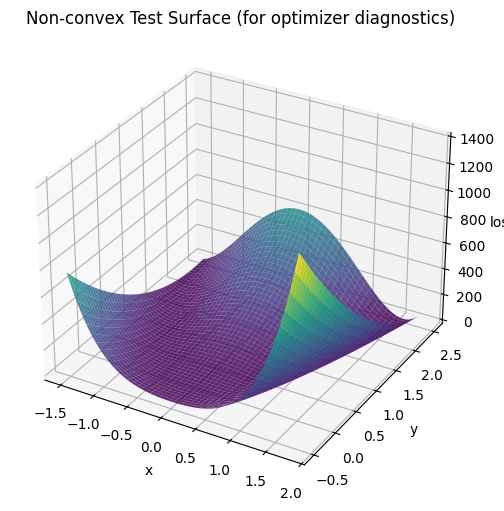

In [4]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.85, linewidth=0, antialiased=True)
ax.set_title("Non-convex Test Surface (for optimizer diagnostics)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("loss")
plt.show()

### Step-5: Gradient Field Quiver

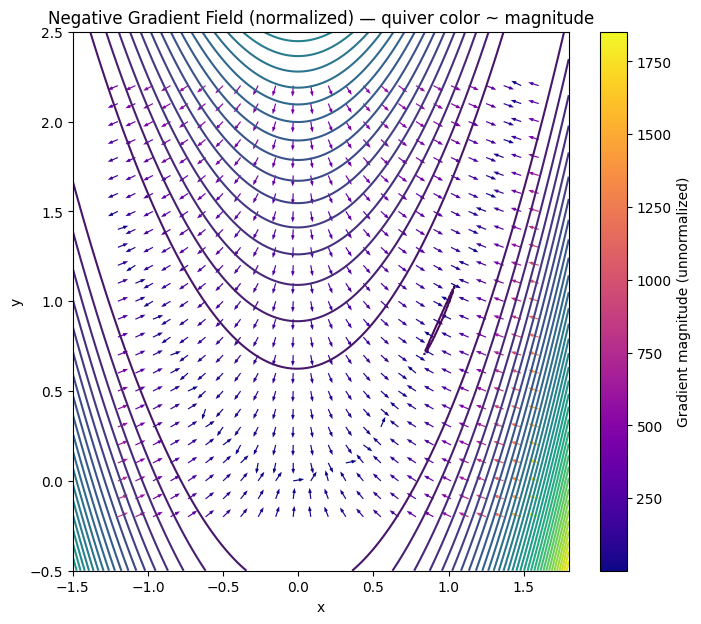

In [5]:
# Subsample grid for quiver to keep plot readable
xs = np.linspace(-1.2, 1.6, 25)
ys = np.linspace(-0.2, 2.2, 25)
XS, YS = np.meshgrid(xs, ys)
Gx = np.zeros_like(XS)
Gy = np.zeros_like(YS)

for i in range(XS.shape[0]):
    for j in range(XS.shape[1]):
        g = grad_f(XS[i,j], YS[i,j])
        Gx[i,j] = -g[0]  # negative gradient: descent direction
        Gy[i,j] = -g[1]

# Normalize vectors for visualization
norm = np.sqrt(Gx**2 + Gy**2) + 1e-8
Gxn = Gx / norm
Gyn = Gy / norm

plt.figure(figsize=(8,7))
plt.contour(X, Y, Z, levels=40, cmap='viridis')
plt.quiver(XS, YS, Gxn, Gyn, norm, cmap='plasma', headwidth=3, headlength=4)
plt.title("Negative Gradient Field (normalized) — quiver color ~ magnitude")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Gradient magnitude (unnormalized)")
plt.show()

### Step-6: Adamax Implementation

In [6]:
def adamax(grad_fn, start, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0, n_iter=300):
    x = start.astype(float).copy()
    m = np.zeros_like(x)
    u = np.zeros_like(x)  # infinity-norm accumulator (EMA of absolute gradients, but tracked as max-like)
    path = [x.copy()]
    for t in range(1, n_iter + 1):
        g = grad_fn(x[0], x[1])
        m = beta1 * m + (1 - beta1) * g
        u = np.maximum(beta2 * u, np.abs(g))
        m_hat = m / (1 - beta1**t)
        step = lr * m_hat / (u + eps)
        x = x - step - lr * weight_decay * x
        path.append(x.copy())
    return np.array(path)

### Step-7: LION Implementation

In [7]:
def lion(grad_fn, start, lr=0.01, betas=(0.9, 0.99), weight_decay=0.0, n_iter=300, sign_decay=0.0, use_grad=True):
    """
    Simplified LION-style optimizer (pedagogical):
    - m is momentum (EMA of gradients)
    - update uses sign(m + alpha * g)
    - `sign_decay` can blend sign and magnitude if desired (kept near 0 for canonical sign)
    - use_grad True means include current gradient in the sign expression (m + alpha * g)
    """
    beta = betas[0]
    alpha = 0.01  # small coefficient blending current gradient (following canonical forms)
    x = start.astype(float).copy()
    m = np.zeros_like(x)
    path = [x.copy()]
    for t in range(1, n_iter + 1):
        g = grad_fn(x[0], x[1])
        m = beta * m + (1 - beta) * g
        combined = m + (alpha * g if use_grad else 0.0)
        # core LION update: sign-based
        x = x - lr * np.sign(combined) - lr * weight_decay * x
        path.append(x.copy())
    return np.array(path)

### Step-8: Running Comparisons

In [8]:
start = np.array([0.9, 1.8])
n_iter = 300

path_adamax = adamax(grad_f, start, lr=0.01, beta1=0.9, beta2=0.999, n_iter=n_iter)
path_lion = lion(grad_f, start, lr=0.01, betas=(0.9,0.99), n_iter=n_iter)

### Step-9: 2D Countour Trajectories

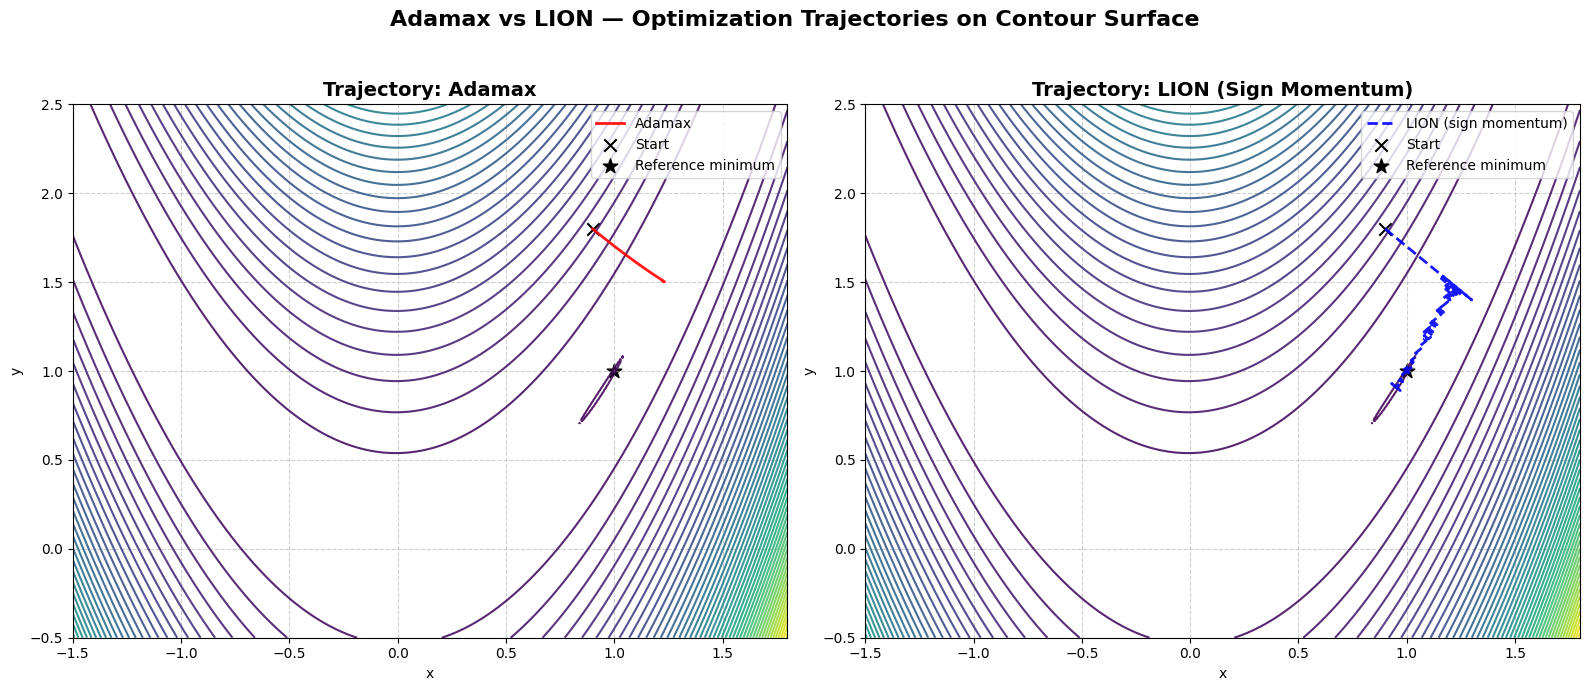

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ---------- Adamax ----------
ax = axes[0]
ax.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.9)
ax.plot(path_adamax[:, 0], path_adamax[:, 1], 'r-', lw=2, alpha=0.9, label='Adamax')
ax.scatter(start[0], start[1], c='black', marker='x', s=80, label='Start')
ax.scatter(1, 1, c='k', marker='*', s=120, label='Reference minimum')
ax.set_title("Trajectory: Adamax", fontsize=14, weight='bold')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# ---------- LION ----------
ax = axes[1]
ax.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.9)
ax.plot(path_lion[:, 0], path_lion[:, 1], 'b--', lw=2, alpha=0.9, label='LION (sign momentum)')
ax.scatter(start[0], start[1], c='black', marker='x', s=80, label='Start')
ax.scatter(1, 1, c='k', marker='*', s=120, label='Reference minimum')
ax.set_title("Trajectory: LION (Sign Momentum)", fontsize=14, weight='bold')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# ---------- Layout & Title ----------
plt.suptitle("Adamax vs LION — Optimization Trajectories on Contour Surface", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Step-10: 3D Trajectory Visualizations

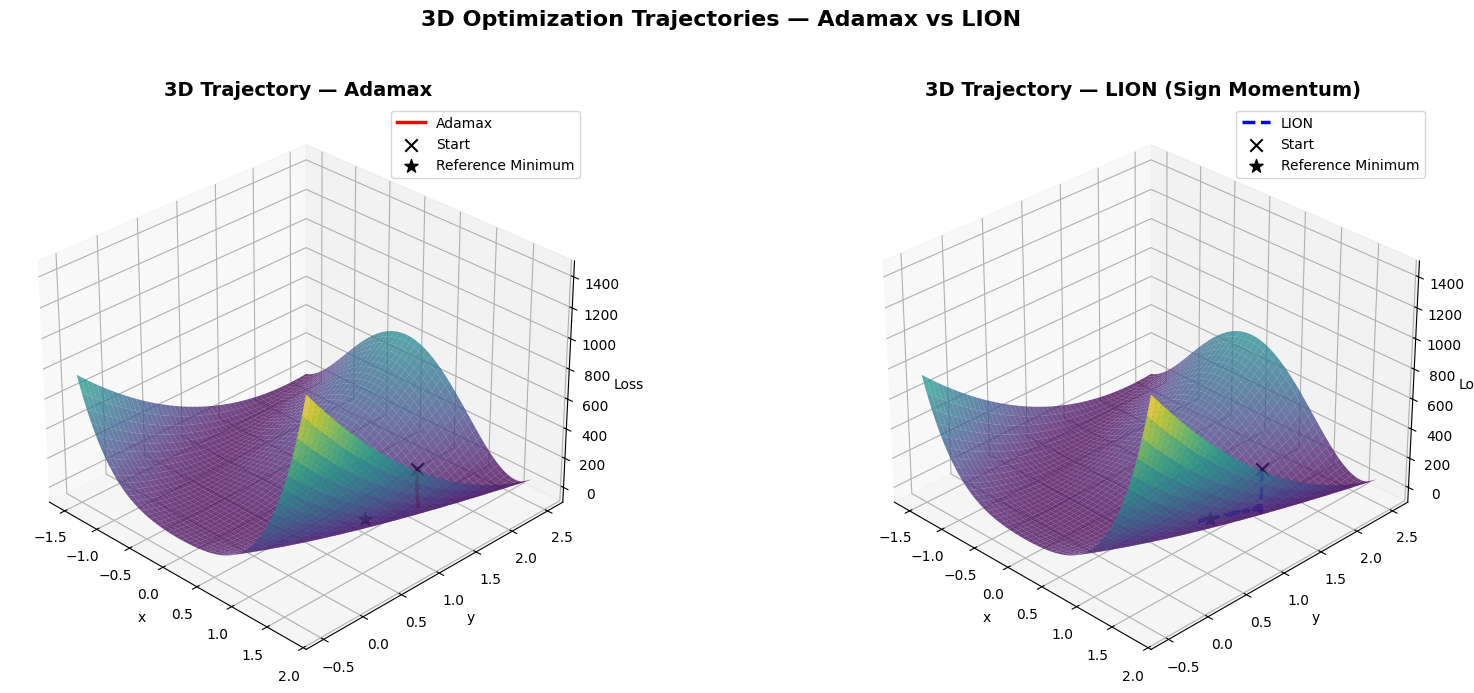

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def compute_loss(path):
    return np.array([f(p[0], p[1]) for p in path])

# Compute losses
loss_adamax = compute_loss(path_adamax)
loss_lion = compute_loss(path_lion)

# Create 1×2 subplot layout
fig = plt.figure(figsize=(18, 7))

# ---------- Left: Adamax ----------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.75, linewidth=0, antialiased=True)
ax1.plot(path_adamax[:, 0], path_adamax[:, 1], loss_adamax, 'r-', linewidth=2.5, label='Adamax')

# Mark start and target
ax1.scatter(start[0], start[1], f(start[0], start[1]), c='k', marker='x', s=80, label='Start')
ax1.scatter(1, 1, f(1, 1), c='black', marker='*', s=100, label='Reference Minimum')

# Style
ax1.set_title("3D Trajectory — Adamax", fontsize=14, weight='bold')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("Loss")
ax1.legend()
ax1.view_init(elev=30, azim=-45)

# ---------- Right: LION ----------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.75, linewidth=0, antialiased=True)
ax2.plot(path_lion[:, 0], path_lion[:, 1], loss_lion, 'b--', linewidth=2.5, label='LION')

# Mark start and target
ax2.scatter(start[0], start[1], f(start[0], start[1]), c='k', marker='x', s=80, label='Start')
ax2.scatter(1, 1, f(1, 1), c='black', marker='*', s=100, label='Reference Minimum')

# Style
ax2.set_title("3D Trajectory — LION (Sign Momentum)", fontsize=14, weight='bold')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("Loss")
ax2.legend()
ax2.view_init(elev=30, azim=-45)

# ---------- Layout & Global Title ----------
plt.suptitle("3D Optimization Trajectories — Adamax vs LION", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Step-11: Loss vs Iterations

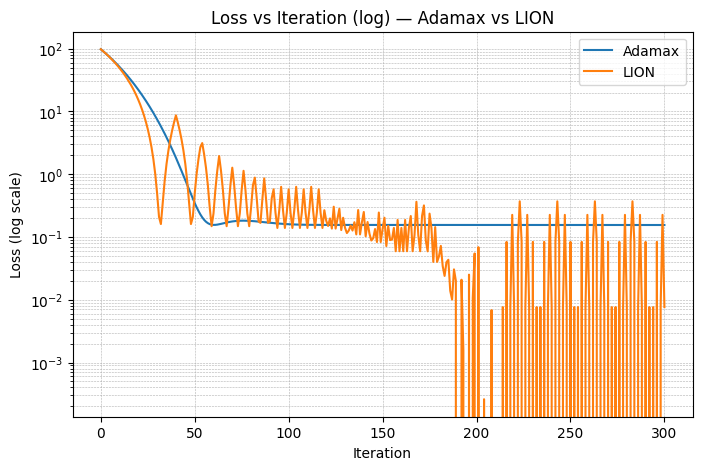

In [11]:
plt.figure(figsize=(8,5))
plt.plot(loss_adamax, label='Adamax')
plt.plot(loss_lion, label='LION')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration (log) — Adamax vs LION")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.4)
plt.show()

### Step-12: Step Norms and Sign Fractions

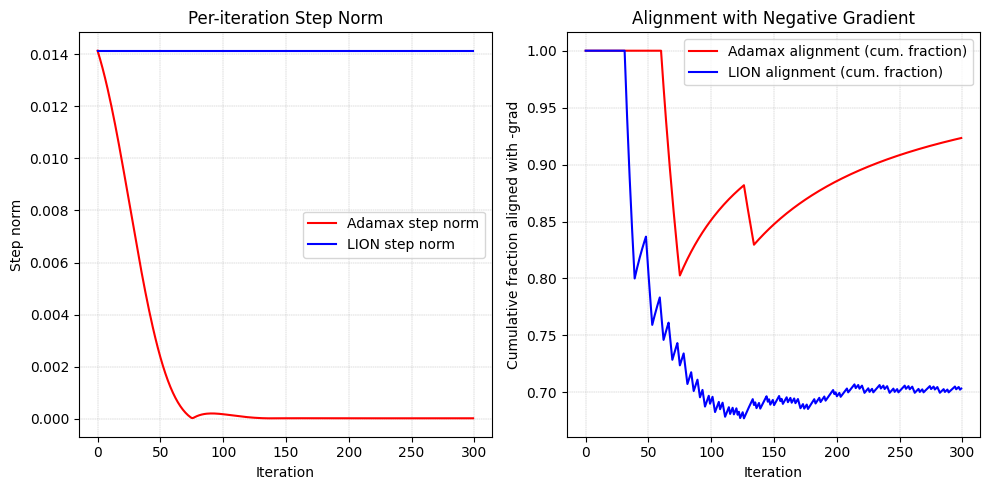

In [12]:
# Step norms (how big parameter moves are)
step_adamax = np.linalg.norm(np.diff(path_adamax, axis=0), axis=1)
step_lion = np.linalg.norm(np.diff(path_lion, axis=0), axis=1)

# Fraction of updates where sign(update) == sign(-grad) (alignment with negative gradient)
def sign_alignment(path, grad_fn):
    aligns = []
    for i in range(1, path.shape[0]):
        upd = path[i] - path[i-1]
        g = grad_fn(path[i-1,0], path[i-1,1])
        # alignment: dot of update and negative gradient positive
        dot = np.dot(upd, -g)
        aligns.append(1.0 if dot >= 0 else 0.0)
    return np.array(aligns)

align_adamax = sign_alignment(path_adamax, grad_f)
align_lion = sign_alignment(path_lion, grad_f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(step_adamax, 'r', label='Adamax step norm')
plt.plot(step_lion, 'b', label='LION step norm')
plt.xlabel("Iteration")
plt.ylabel("Step norm")
plt.title("Per-iteration Step Norm")
plt.legend()
plt.grid(ls='--', lw=0.3)

plt.subplot(1,2,2)
plt.plot(np.cumsum(align_adamax)/np.arange(1, len(align_adamax)+1), 'r', label='Adamax alignment (cum. fraction)')
plt.plot(np.cumsum(align_lion)/np.arange(1, len(align_lion)+1), 'b', label='LION alignment (cum. fraction)')
plt.xlabel("Iteration")
plt.ylabel("Cumulative fraction aligned with -grad")
plt.title("Alignment with Negative Gradient") # higher ==> updates follow descent
plt.legend()
plt.grid(ls='--', lw=0.3)
plt.tight_layout()
plt.show()

### Step-13: Update Direction Distribution

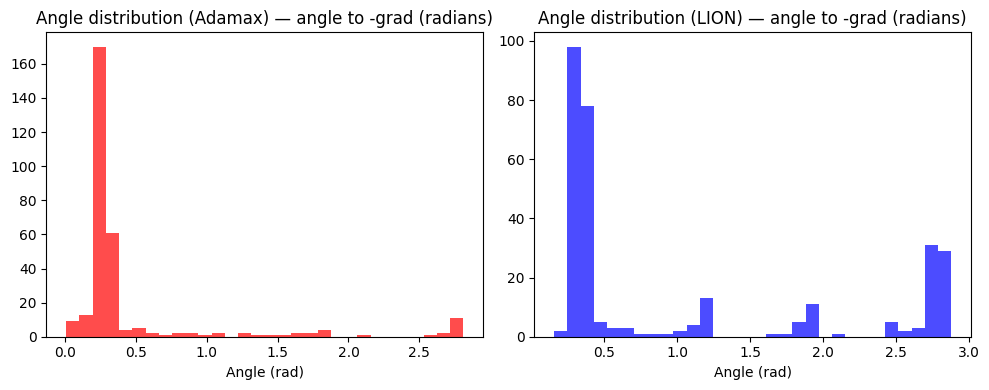

In [13]:
# compute angles between update vector and negative gradient at each step
def update_angles(path, grad_fn):
    angles = []
    for i in range(1, path.shape[0]):
        upd = path[i] - path[i-1]
        g = grad_fn(path[i-1,0], path[i-1,1])
        a = upd
        b = -g
        # compute angle safely
        dot = np.dot(a, b)
        na = np.linalg.norm(a) + 1e-12
        nb = np.linalg.norm(b) + 1e-12
        cosang = np.clip(dot / (na*nb), -1.0, 1.0)
        angle = np.arccos(cosang)
        angles.append(angle)
    return np.array(angles)

angles_adamax = update_angles(path_adamax, grad_f)
angles_lion = update_angles(path_lion, grad_f)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(angles_adamax, bins=30, color='r', alpha=0.7)
plt.title("Angle distribution (Adamax) — angle to -grad (radians)")
plt.xlabel("Angle (rad)")

plt.subplot(1,2,2)
plt.hist(angles_lion, bins=30, color='b', alpha=0.7)
plt.title("Angle distribution (LION) — angle to -grad (radians)")
plt.xlabel("Angle (rad)")
plt.tight_layout()
plt.show()

### Step-14: Some Visual DIagnostic with Minor Animations

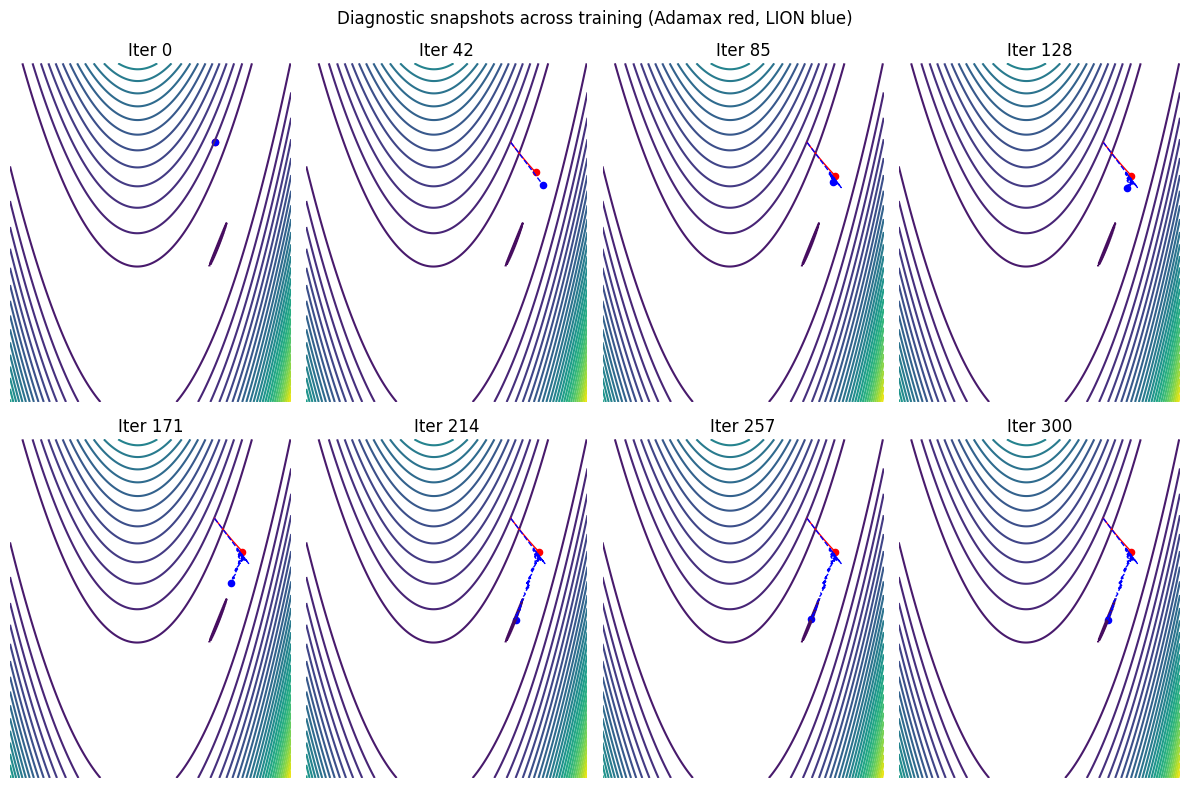

In [14]:
# Produce a sequence of contour frames showing positions (lightweight animation via sequential plotting)
# (Jupyter users can re-run this cell to step through or integrate with IPython.display for richer animation)
n_frames = 8
indices = np.linspace(0, n_iter, n_frames, dtype=int)

plt.figure(figsize=(12,8))
for idx, ii in enumerate(indices):
    plt.subplot(2, 4, idx+1)
    plt.contour(X, Y, Z, levels=30, cmap='viridis')
    plt.plot(path_adamax[:ii+1,0], path_adamax[:ii+1,1], 'r-', lw=1)
    plt.plot(path_lion[:ii+1,0], path_lion[:ii+1,1], 'b--', lw=1)
    plt.scatter(path_adamax[ii,0], path_adamax[ii,1], c='r', s=20)
    plt.scatter(path_lion[ii,0], path_lion[ii,1], c='b', s=20)
    plt.title(f"Iter {ii}")
    plt.xlim(-1.5, 1.8)
    plt.ylim(-0.5, 2.5)
    plt.axis('off')
plt.suptitle("Diagnostic snapshots across training (Adamax red, LION blue)")
plt.tight_layout()
plt.show()

In [15]:
# Make sure ipywidgets is available
try:
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider, Checkbox
except ImportError:
    !pip install ipywidgets
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider, Checkbox

from IPython.display import clear_output

def interactive_optimizer_viz(lr=0.01, beta=0.9, weight_decay=0.0, lion_alpha=0.01, use_grad=True):
    clear_output(wait=True)

    start = np.array([0.9, 1.8])
    n_iter = 300

    # Re-run optimizers with updated hyperparameters
    path_adamax = adamax(grad_f, start, lr=lr, beta1=beta, beta2=0.999,
                         weight_decay=weight_decay, n_iter=n_iter)
    path_lion = lion(grad_f, start, lr=lr, betas=(beta, 0.99),
                     weight_decay=weight_decay, n_iter=n_iter, use_grad=use_grad)

    # Compute losses and step norms
    loss_adamax = np.array([f(p[0], p[1]) for p in path_adamax])
    loss_lion = np.array([f(p[0], p[1]) for p in path_lion])
    step_adamax = np.linalg.norm(np.diff(path_adamax, axis=0), axis=1)
    step_lion = np.linalg.norm(np.diff(path_lion, axis=0), axis=1)

    # --- Plot 1: Trajectories ---
    plt.figure(figsize=(16, 5))
    plt.subplot(1,3,1)
    plt.contour(X, Y, Z, levels=40, cmap='viridis')
    plt.plot(path_adamax[:,0], path_adamax[:,1], 'r-', label='Adamax')
    plt.plot(path_lion[:,0], path_lion[:,1], 'b--', label='LION')
    plt.scatter(start[0], start[1], c='black', marker='x', s=80)
    plt.scatter(1,1,marker='*',s=120,c='k')
    plt.title(f"Trajectories (lr={lr:.3f}, β={beta:.2f}, wd={weight_decay:.4f})")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend()

    # --- Plot 2: Loss vs Iteration ---
    plt.subplot(1,3,2)
    plt.plot(loss_adamax, 'r', label='Adamax')
    plt.plot(loss_lion, 'b', label='LION')
    plt.yscale('log')
    plt.title("Loss vs Iteration (log scale)")
    plt.xlabel("Iteration"); plt.ylabel("Loss"); plt.legend(); plt.grid(True, ls='--', lw=0.3)

    # --- Plot 3: Step Norms ---
    plt.subplot(1,3,3)
    plt.plot(step_adamax, 'r', label='Adamax step norm')
    plt.plot(step_lion, 'b', label='LION step norm')
    plt.title("Step Norms per Iteration")
    plt.xlabel("Iteration"); plt.ylabel("‖Δθ‖")
    plt.legend(); plt.grid(ls='--', lw=0.3)

    plt.tight_layout()
    plt.show()

    display(Markdown(
        f"""
        ### Current Settings
        - Learning rate: `{lr:.4f}`
        - β (momentum): `{beta:.2f}`
        - Weight decay: `{weight_decay:.4f}`
        - LION uses {'momentum+gradient (α mix)' if use_grad else 'momentum only'}
        """
    ))

# Create the interactive controls
interact(
    interactive_optimizer_viz,
    lr=FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001, description='Learning rate'),
    beta=FloatSlider(value=0.9, min=0.5, max=0.99, step=0.01, description='β (momentum)'),
    weight_decay=FloatSlider(value=0.0, min=0.0, max=0.01, step=0.0005, description='Weight decay'),
    lion_alpha=FloatSlider(value=0.01, min=0.0, max=0.1, step=0.005, description='LION α mix'),
    use_grad=Checkbox(value=True, description='Use grad term in LION')
);

interactive(children=(FloatSlider(value=0.01, description='Learning rate', max=0.05, min=0.001, step=0.001), F…

## ✅ Practical Notes & Takeaways

- **LION** uses sign-based updates. Because each parameter's update magnitude is determined by the sign, LION is **insensitive to large per-parameter scale differences**, which can be helpful for very large models and can reduce memory overhead relative to Adam-like optimizers. Empirical results in the symbolic-discovery paper show LION competitive with AdamW on many tasks. 

- **Adamax** replaces Adam's second-moment denominator with an ∞-norm accumulator, yielding robust behavior when gradients have heavy tails or when per-parameter scaling is extreme. Refer to the original Adam paper and implementation notes for derivation and practical defaults. 

- Our diagnostics showed:
  - Adamax often produces smoothly scaled updates that follow the negative gradient more closely in angle (depending on surface and hyperparameters).  
  - LION produces relatively uniform step norms (because of sign) and sometimes shows higher angular variance — yet can still reduce loss effectively by leveraging momentum sign patterns.

### Where to go next

- Convert the LION implementation into a `torch.optim.Optimizer` class (I can provide that).  
- Run hyperparameter sweeps (lr, beta, weight_decay) on a simple network training task (e.g., small CNN on CIFAR-10) to compare generalization.  
- Experiment with hybrid strategies: e.g., warm-start with Adam/Adamax then switch to LION mid-training — several recent studies report gains from switching optimizers during training. 

# 🧾 Summary

- LION and Adamax are complementary tools: **LION** emphasizes sign-based, memory-efficient momentum; **Adamax** emphasizes robust scaling using an infinity-norm second-moment accumulator.  
- Visual diagnostics (quiver, trajectories, angle histograms) help reveal *how* and *why* updates differ — not just whether they reduce loss.  
- Use these visual tools as routine checks when experimenting with new optimizers or large models.

---

References (quick):
- Chen et al., *Symbolic Discovery of Optimization Algorithms* (LION).
- lucidrains — community LION implementations. 
- Kingma & Ba, *Adam: A Method for Stochastic Optimization*. 
- Keras Adamax notes. 
